# Image Analysis in python


## Setup

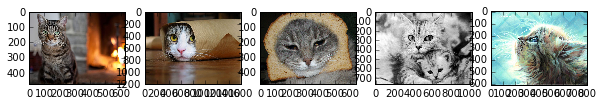

In [7]:
# Bring in necessary libraries
## Adds all the needed python libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import color
import skimage.filters as filters
import skimage.exposure as exposure
import skimage.feature as feature
from skimage.transform import hough_circle
from skimage.feature import peak_local_max
from skimage import morphology
from skimage.draw import circle_perimeter
from skimage import img_as_float, img_as_ubyte, img_as_uint
from skimage import segmentation as seg
from skimage.morphology import watershed
from skimage.morphology import disk
from scipy import ndimage as nd
from scipy.ndimage import convolve
import glob # for bulk file import

# Set defaults
## Sets the default settings for the images. We set the default size,
## and grayscale images are in grayscale.
plt.rcParams['image.cmap'] = 'gray' # Display grayscale images in... grayscale.
plt.rcParams['image.interpolation'] = 'none' # Use nearest-neighbour
plt.rcParams['figure.figsize'] = 10, 10

# Import test images
## Import all of the images that are jpgs and pngs. Save them as
## 8-bit unsigned integer format.
imgpaths = glob.glob("./images/*.jpg") + glob.glob("./images/*.png")
imgset = [img_as_ubyte(mpimg.imread(x)) for x in imgpaths]

# Display thumbnails of the images to ensure loading
## Loads the images as thumbnails. No other changes have been made,
## uses the default settings. Grayscales are still grayscale.
plt.figure()
for i,img in enumerate(imgset):
    plt.subplot(1, len(imgset), i+1)
    plt.imshow(img, cmap = 'gray')

In [35]:
# Plot the circular Hough transforms of an image at the given radii.
def plot_circle_hough(img, radii, sigma):
    edges = feature.canny(img, sigma)
    hough = hough_circle(edges, radii)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(imgbw)
    plt.subplot(1, 2, 2)
    plt.imshow(edges)
    plt.figure()
    for j in range(len(hough)):
        if len(hough)==0: continue
        plt.subplot(1, len(hough), j)
        plt.imshow(hough[j,:,:])    

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)
/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


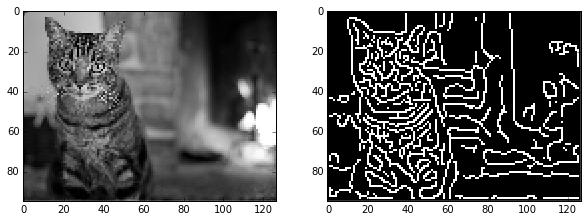

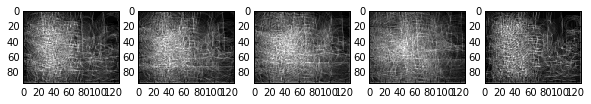

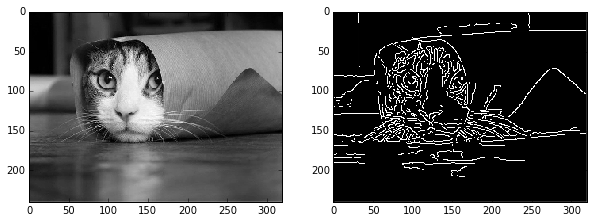

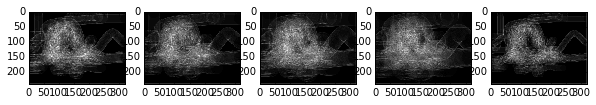

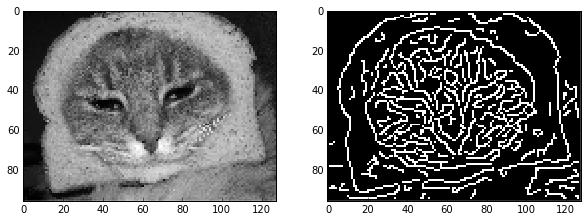

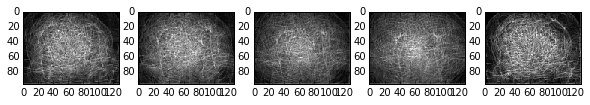

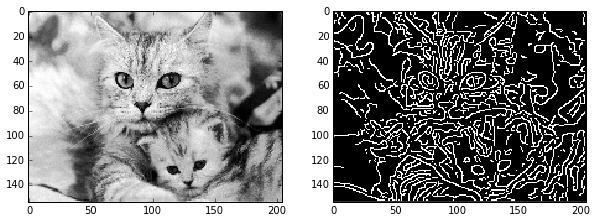

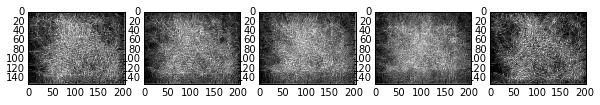

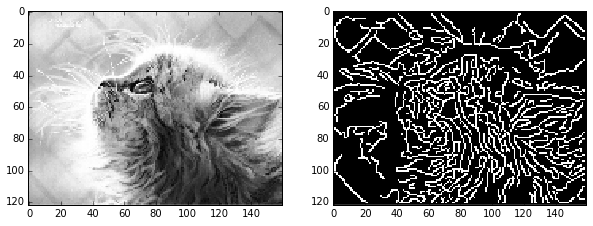

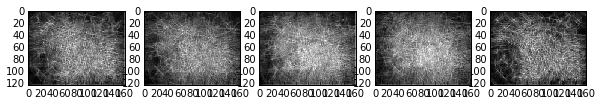

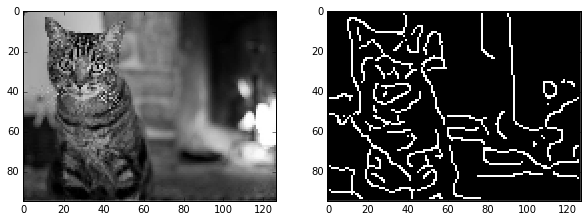

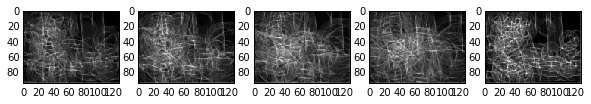

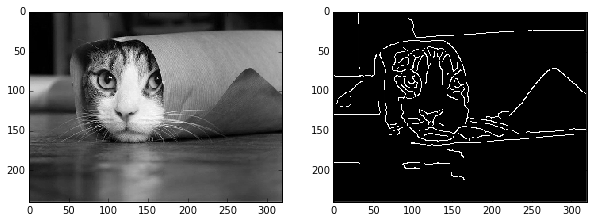

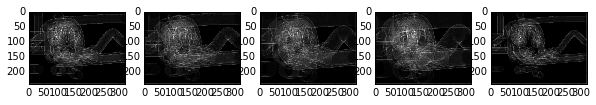

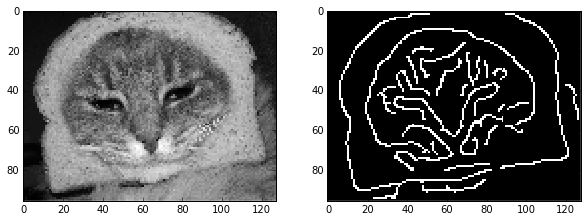

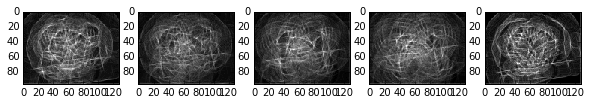

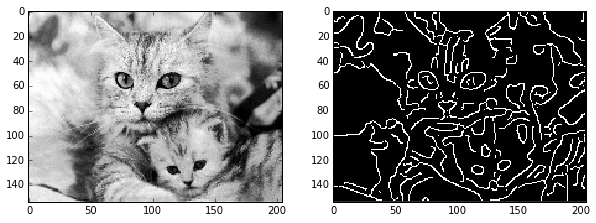

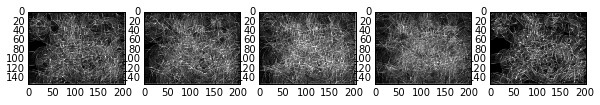

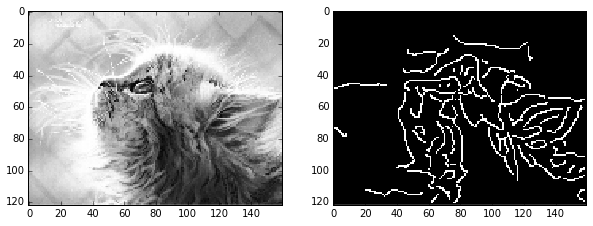

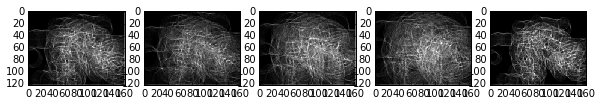

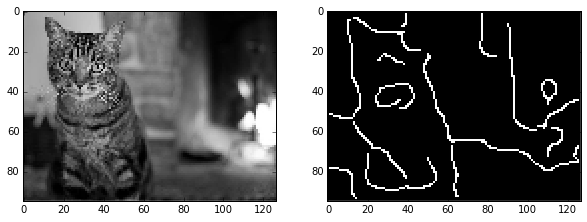

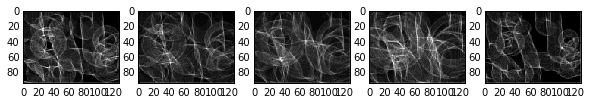

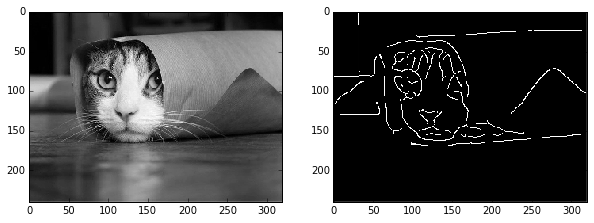

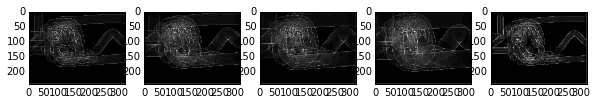

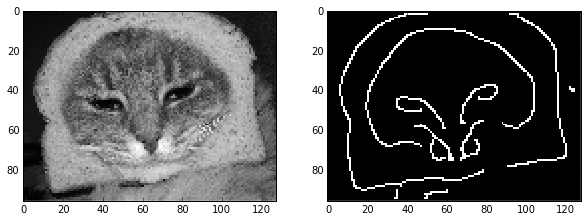

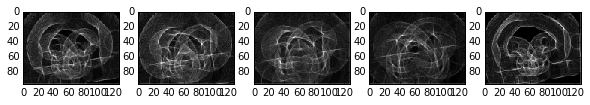

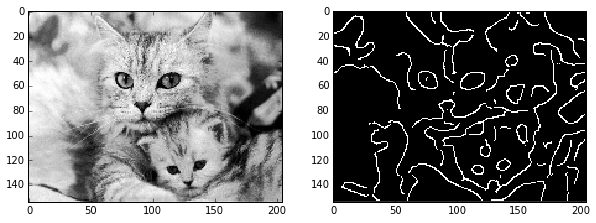

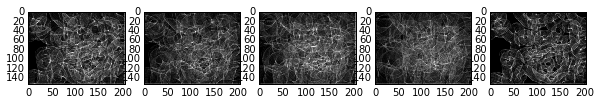

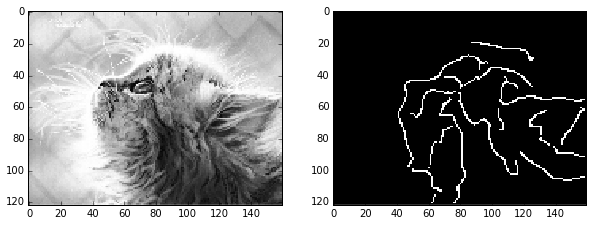

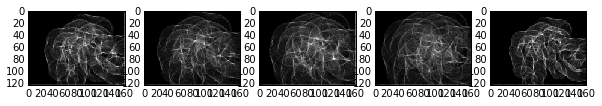

In [36]:
# Apply to image set
for sigma in range (1, 4):
    radii = np.arange(10, 35, 5)
    for i,img in enumerate(imgset):
        imgbw = img_as_float(color.rgb2grey(decimate_image(img, 5))) # downsample to make it easier to see graphs
        plot_circle_hough(imgbw, radii, sigma)

## Morphological Operations

### Morphological operations - de-noising

In [37]:
# Applies a morphological operator to remove noise
def morpho_denoise(img, shape, size):
    if shape == 'square':
        kernel = morphology.square(width=size)
    elif shape == 'diamond':
        kernel = morphology.diamond(radius=size)
    else:
        print("Shape must be 'square' or 'diamond'.")
        return None
    return morphology.opening(img, kernel)

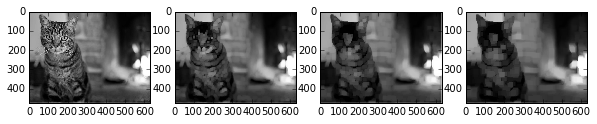

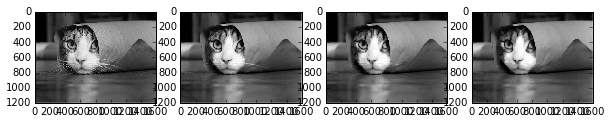

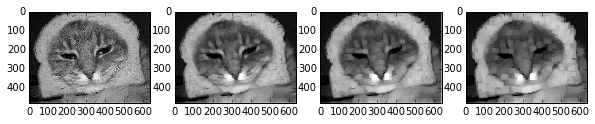

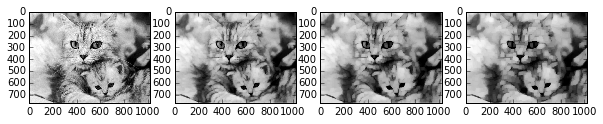

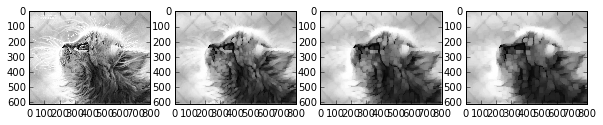

In [38]:
# Apply to image set
for i,img in enumerate(imgset):
    imgbw = img_as_float(color.rgb2grey(img))
    plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(imgbw)
    plt.subplot(1, 4, 2)
    plt.imshow(morpho_denoise(imgbw, 'square', 10))
    plt.subplot(1, 4, 3)
    plt.imshow(morpho_denoise(imgbw, 'square', 15))
    plt.subplot(1, 4, 4)
    plt.imshow(morpho_denoise(imgbw, 'square', 20))

## Segmentation

### SLIC (Simple Linear Iterative Clustering)

In [39]:
# Calculate the mean color of slic regions, from the SciKit tutorial
def mean_color(image, labels):
    out = np.zeros_like(image)
    for label in np.unique(labels):
        indices = np.nonzero(labels == label)
        out[indices] = np.mean(image[indices], axis=0)
    return out

def plot_slic_segmentation(img):
    labels = seg.slic(img, n_segments=24, compactness=70, sigma=2.0, enforce_connectivity=True)
    return mean_color(img, labels)

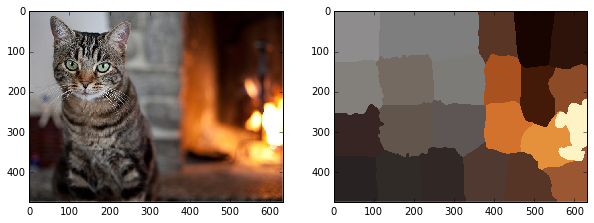

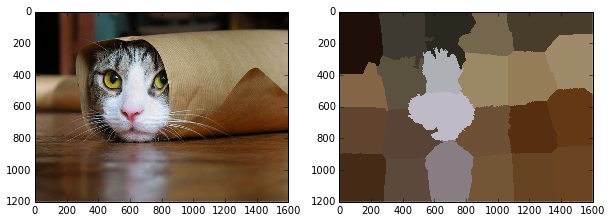

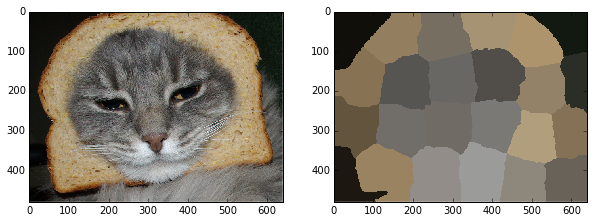

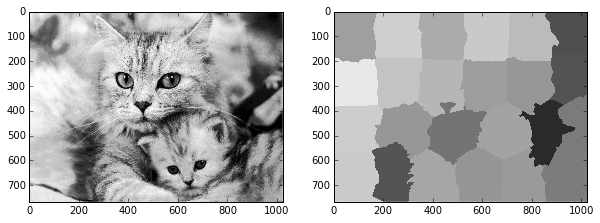

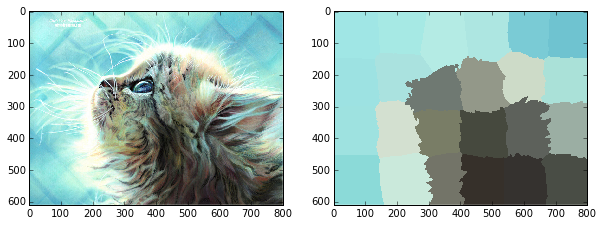

In [40]:
# Apply to the images
for i,img in enumerate(imgset):
    rgbimg = img_as_float(color.gray2rgb(img))
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(plot_slic_segmentation(rgbimg))

### Watershed algorithm

In [41]:
# Show a watershed plot of an image
def plot_watershed(img, sigma):
    edges = feature.canny(img, sigma)
    distance_from_edge = nd.distance_transform_edt(-edges)
    peaks = peak_local_max(distance_from_edge)
    peaks_image = np.zeros(img.shape, np.bool)
    peaks_image[tuple(np.transpose(peaks))] = True
    seeds, num_seeds = nd.label(peaks_image)
    plt.plot(peaks[:, 1], peaks[:, 0], 'ro')
    ws = watershed(edges, seeds)
    plt.imshow(color.label2rgb(ws, img))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


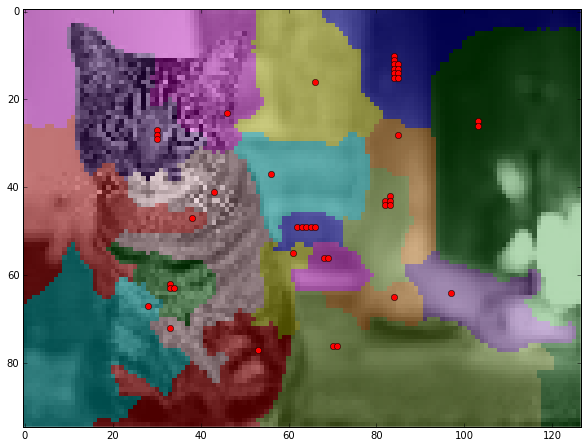

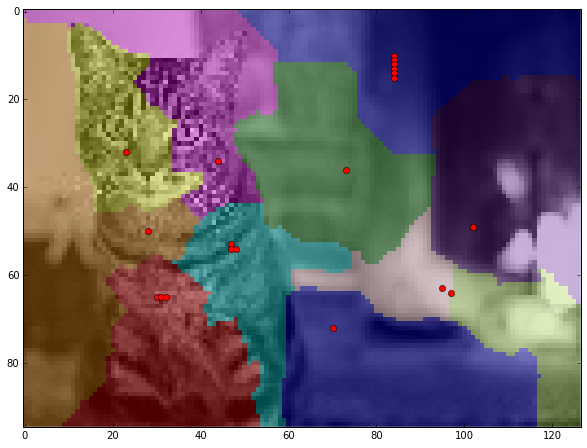

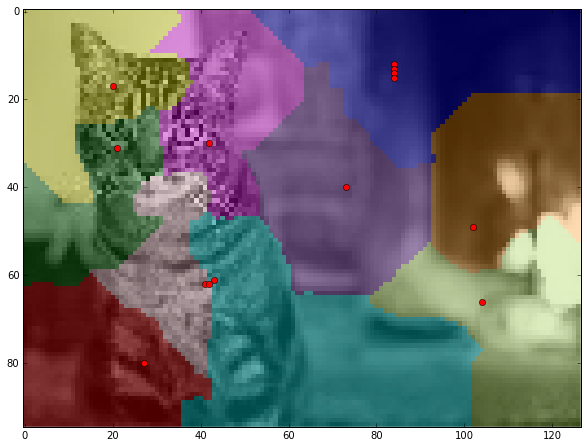

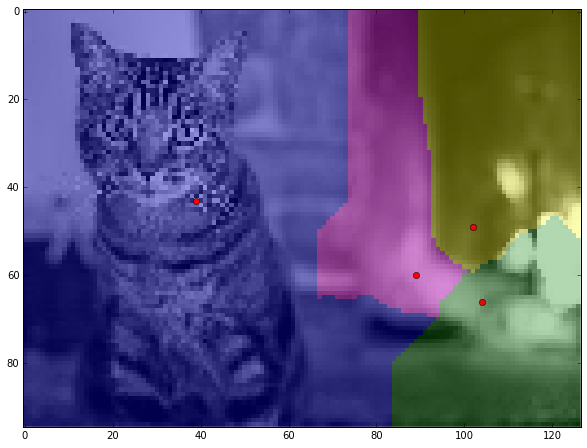

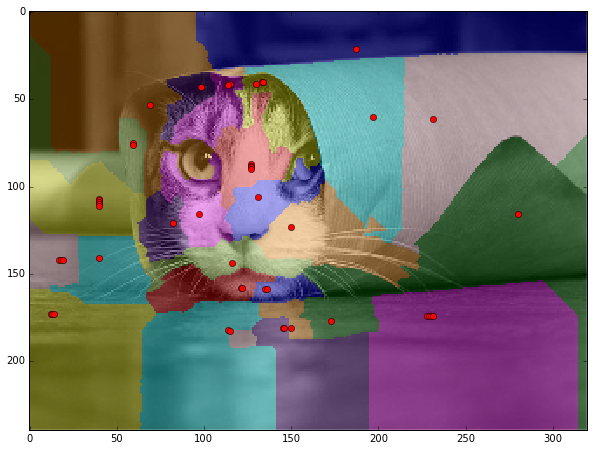

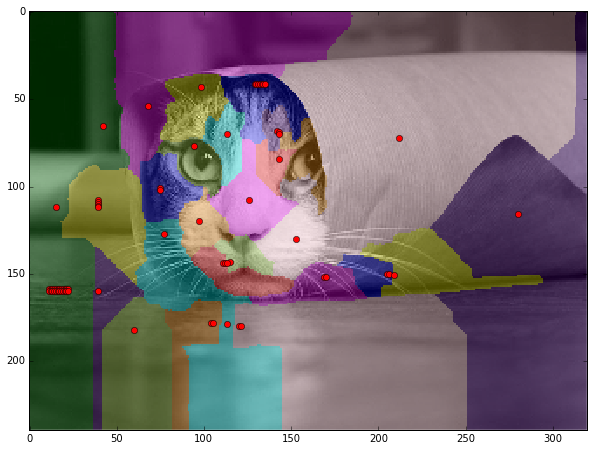

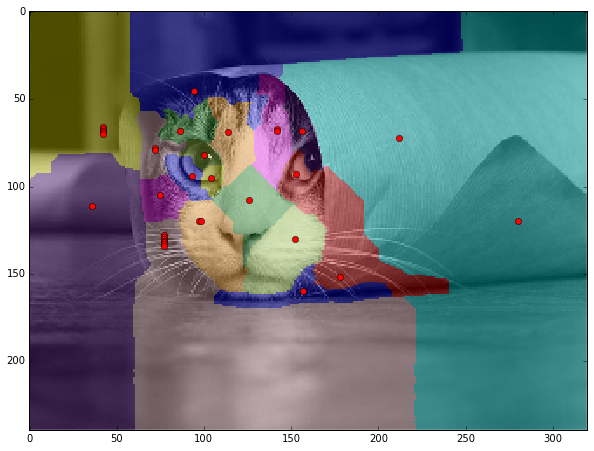

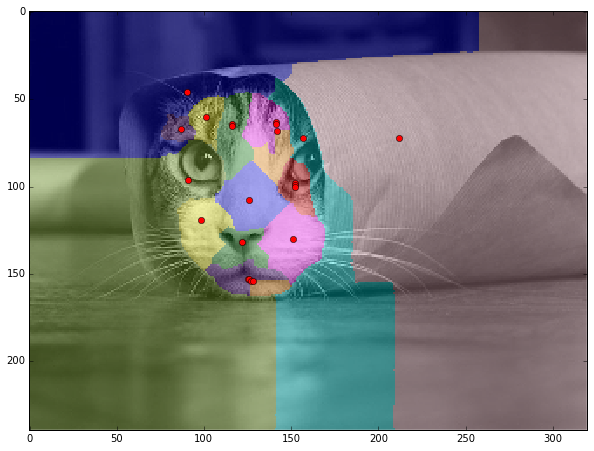

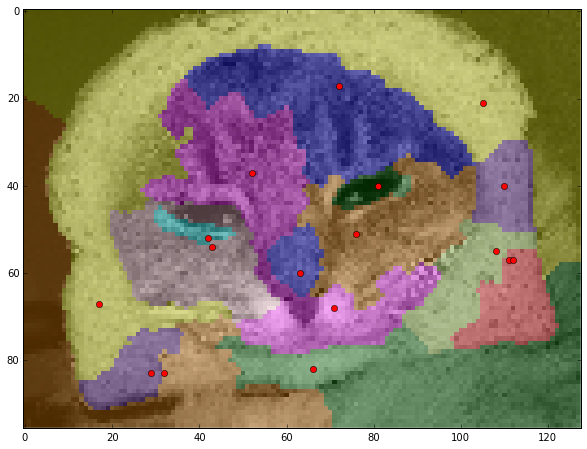

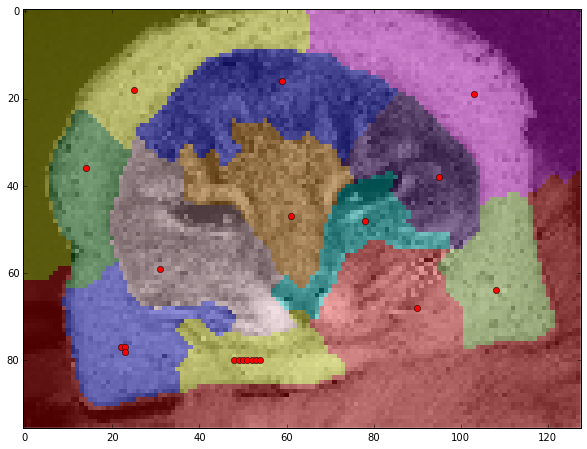

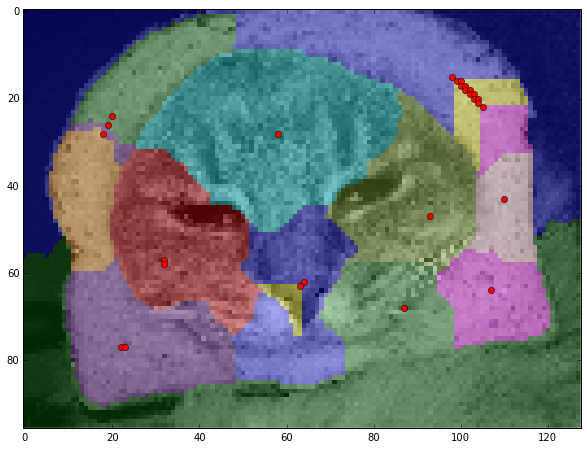

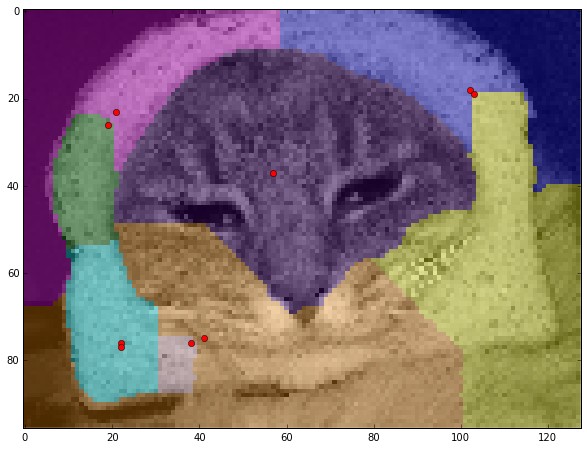

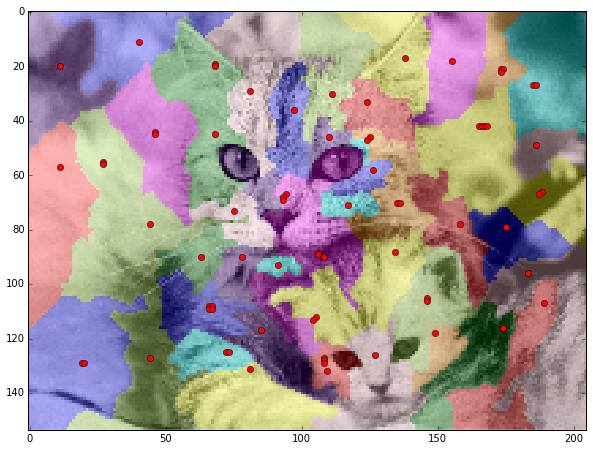

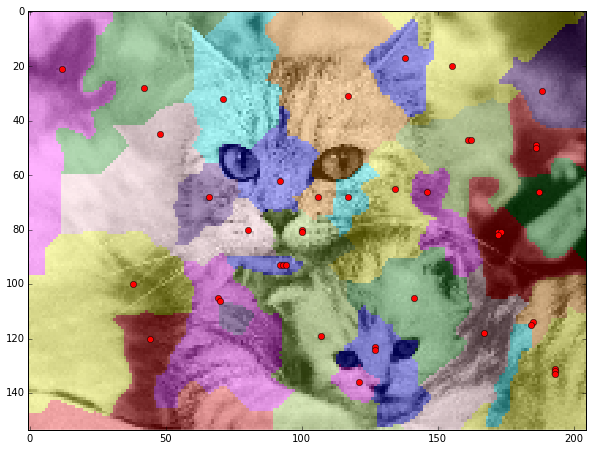

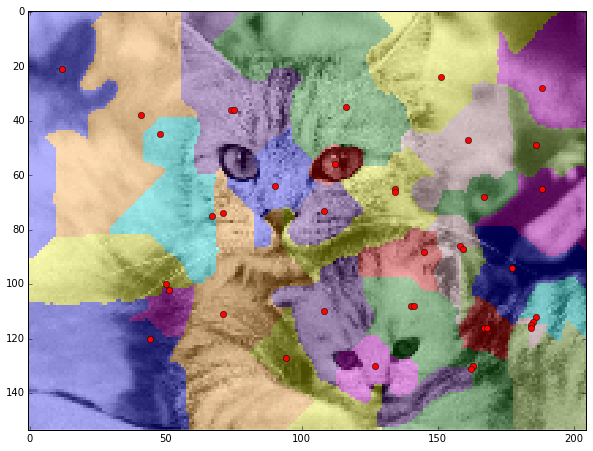

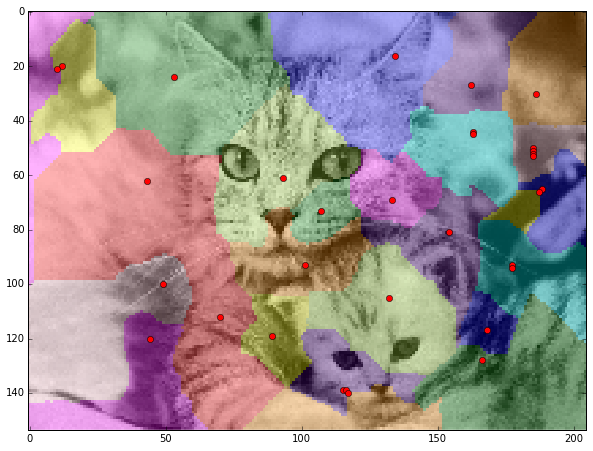

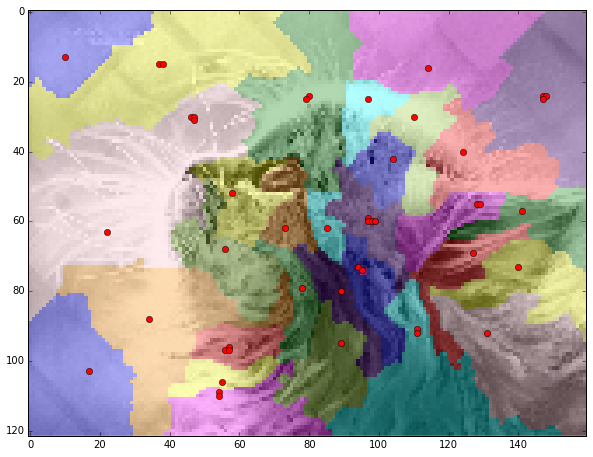

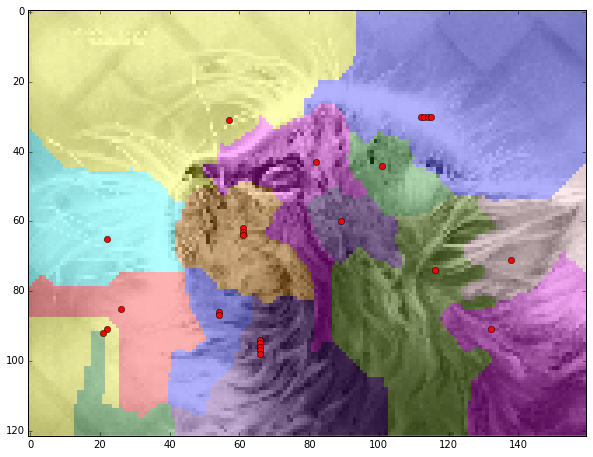

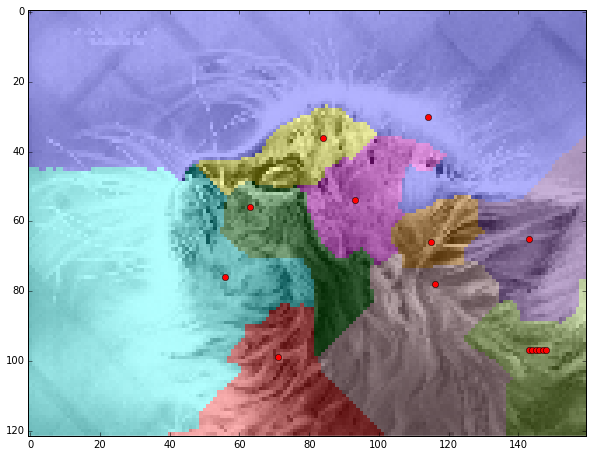

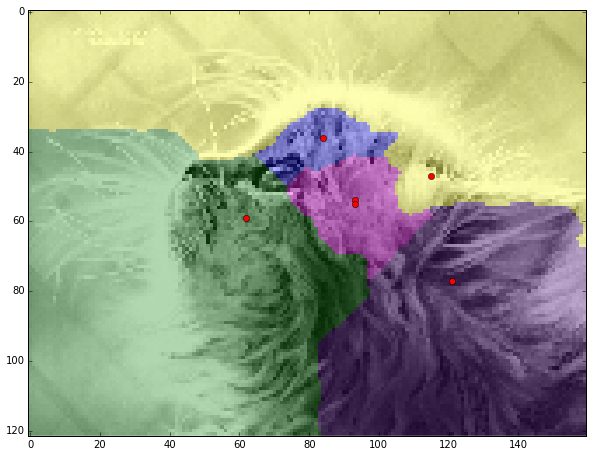

In [42]:
# Apply to the images
for i,img in enumerate(imgset):
    for x in range (1, 5):
        imgbw = (color.rgb2grey(decimate_image(img, 5)))
        plt.figure()
        plot_watershed(imgbw, x)